In [1]:
#
import tensorflow as tf
print(tf.__version__)

import pandas as pd
import io
from google.colab import files

import numpy as np
import matplotlib.pyplot as plt
import scipy 
import seaborn as sns
import random

import keras
from scipy.sparse.linalg import lsmr


2.5.0


In [ ]:
# set this path 
din = './input_data/'
dout = './input_data/'

# functions, layers, constants

In [2]:
WT_PARE_AA = "MAVRLVWSPTAKADLIDIYVMIGSENIRAADRYYDQLEARALQLADQPRMGVRRPDIRPSARMLVEAPFVLLYETVPDTDDGPVEWVEIVRVVDGRRDLNRLF*"
WT_PARD_AA = "MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTEVPPNGR*"


In [3]:
# layers used
class log_layer_scale_shift(tf.keras.layers.Layer): # derive this layer from keras

  def __init__(self, num_outputs, reg_strength=0):
    super(log_layer_scale_shift, self).__init__()
    self.num_outputs = num_outputs
    self.reg_strength = reg_strength

    # how much to scale by
    scale_init = tf.ones_initializer()
    self.scale = tf.Variable(name='scale',
                             initial_value = scale_init(shape=(1,), 
                                                        dtype='float32'),
                             trainable=True
                             )
    
    # how much to shift by
    shift_init = tf.ones_initializer()
    self.shift = tf.Variable(name='shift',
                             initial_value = shift_init(shape=(1,), 
                                                        dtype='float32'),
                             trainable=True
                             )
    
  def build(self, input_shape):
    #linear regression weights
    self.w = self.add_weight("w",
                            shape=(int(input_shape[-1]), self.num_outputs),
                             initializer='random_normal',
                             trainable=True,
                             regularizer = tf.keras.regularizers.L1(self.reg_strength)
                             )
    
  def call(self, input):
    return tf.multiply(
        tf.sigmoid(tf.matmul(input, self.w)), 
        self.scale ) - self.shift


def fit_log_model(Xb, Y, rand_seed=3,
                  my_layer = log_layer_scale_shift(1), # default layer is log_layer_scale,
                  init_linear = True, 
                  init_list=[],
                  adam_lr =1,
                  checkpoint_filepath = './tmp/checkpoint',
                  val_data = None
                  ):
    np.random.seed(rand_seed)
    tf.random.set_seed(rand_seed)

    # set up the model
    my_log_layer = my_layer
    my_log_layer.build(Xb.shape)
    model = tf.keras.Sequential([my_log_layer])

    # Compile model
    model.compile(loss=tf.keras.losses.MeanSquaredError(),#tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate = adam_lr))

    #initialize with linear regression
    beta_hat = lsmr(Xb,
        Y,
        show=False)[0]

    layer0_weights = model.layers[0].get_weights()
    n_weights = len(layer0_weights)
    weights_init = [np.array(8).reshape(1,)] * n_weights
    weights_init[-1] = np.array(beta_hat).reshape(-1,1)
    print(weights_init[-1].shape)
    model.layers[0].set_weights(weights_init)
    print('layer0 weights set to: ',model.layers[0].get_weights()[-1][:5])
    print('beta_hat', beta_hat[:5])

    # initialize with init_list
    if init_list != []:
        model.layers[0].set_weights(init_list)

    #need to take the full epoch loss, that is over the full data.
    batch_weight_history = []
    batch_loss_history = []
    epoch_weight_history = []
    epoch_loss_history = []
    class MyCallback(keras.callbacks.Callback):
        def on_batch_end(self, batch, logs=None):
            weights = model.get_weights()
            batch_weight_history.append(weights)
            loss = logs['loss']
            batch_loss_history.append(logs['loss'])
        
        def on_epoch_end(self, epoch, logs=None):
            weights = model.get_weights()
            epoch_weight_history.append(weights)
            loss = logs['loss']
            epoch_loss_history.append(logs['loss'])
        
    callback = MyCallback()

    if val_data == None:
        var_monitor = 'loss'
    else:
        var_monitor = 'val_loss'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                    filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor=var_monitor,
                                    mode='min',
                                    save_best_only=True)

    # Train the model
    history = model.fit(Xb, Y, 
                        epochs=200, 
                        batch_size = 1000,# 1000
                        verbose=False,
                        callbacks=[callback, model_checkpoint_callback],
                        validation_data = val_data
                        )

    # plot the training loss
    plt.figure()
    plt.title('history of loss by epoch, min: {}'.format(min(np.array(history.history['loss']))))
    plt.xlabel('Epoch Number')
    plt.ylabel("Loss Magnitude")
    plt.plot(np.array(history.history['loss']))
    plt.show()

    model.load_weights(checkpoint_filepath)
    return model, history, [batch_weight_history, batch_loss_history, epoch_weight_history, epoch_loss_history]


In [4]:
def get_mut_fl_seq(wt_seq, mut):
    # convert a mut to a full sequence mutation
    wt_aa = mut[0]
    aa_pos = int(mut[1:-1])
    mut_aa = mut[-1]

    assert wt_seq[aa_pos] == wt_aa

    mut_fl_seq = wt_seq[:aa_pos] + mut_aa + wt_seq[aa_pos+1:]
    return mut_fl_seq

def flatten_df_singles(df_singles_toxic, at_mut_order):
    '''
    takes a df_singles, with columns at+'_mean_fit', at+'_neg_log_p_tail'
    and returns a df with columns 'at_mut', 't_mut', 'mean_fit','neg_log_p_tail'
    :param df_singles_toxic:
    :return:
    '''
    cols = ['at_mut', 't_mut', 'mean_fit','neg_log_p_tail']
    df_flat = pd.DataFrame(columns=cols)
    for at_mut in at_mut_order:
        df_curr = df_singles_toxic[[at_mut + '_mean_fit', at_mut + '_neg_log_p_tail']]
        #print(df_curr.head())
        for t_mut, r  in df_curr.iterrows():
            mean_fit = r[at_mut+'_mean_fit']
            nlpt = r[at_mut + '_neg_log_p_tail']
            df_flat = df_flat.append(dict(zip(cols, [at_mut, t_mut, mean_fit, nlpt])), ignore_index=True)
    return df_flat

#not in nt yet
def get_b_idx_oh(b_idx, k):
    oh = np.zeros(k)
    oh[b_idx] = 1
    return oh

# function to decode the one hot encoding
def oh_to_mutstr(t_idx_to_t_bg, b_idx_to_bg, oh_all_cross):
    aas = np.where(oh_all_cross == 1)[0]
    print(aas)
    t_idx = aas[0]
    
    t_mut_single = t_idx_to_t_bg[t_idx]

    at_idx = aas[1] - len(t_bg_to_t_idx)
    at_mut_single = b_idx_to_bg[at_idx]

    if len(aas) == 3:
        # if there is a outer product, it should be the at and t combined.
        # but decode that to make sure that the outer product is uniquely indicated.
        n_bs = len(b_idx_to_bg)
        n_ts = len(t_idx_to_t_bg)

        # oh_all_cross is a 1D, and first has the bg index, and t_mut index.
        # take th rest and reshape that into bs by ts.
        cross_reshaped = oh_all_cross[( n_ts + n_bs):].reshape( n_ts, n_bs)
        (t_idx, bg_idx) = np.where(cross_reshaped ==1)
        print(t_idx, bg_idx)
        #print(t_idx)
        t_mut = t_idx_to_t_bg[t_idx[0]]

        at_mut = b_idx_to_bg[bg_idx[0]]

        cross_mut = t_mut +'.'+ at_mut
        print(cross_mut)


    return t_mut_single, at_mut_single, cross_mut

def muts_to_oh(muts, t_bg_to_t_idx, bg_to_b_idx):
    # convert a mut D34E,A80L,D34E.A80L to one hot encoded vector.
    
    ind_muts = muts.split(',')

    if len(ind_muts) == 2:
        t_mut, at_mut = ind_muts
    elif len(ind_muts) == 3:
        t_mut, at_mut, cross_mut = ind_muts
    
    t_idx = t_bg_to_t_idx[t_mut]
    at_idx = bg_to_b_idx[at_mut]

    t_oh = get_b_idx_oh(t_idx, len(t_bg_to_t_idx))
    at_oh = get_b_idx_oh(at_idx, len(bg_to_b_idx))

    if len(ind_muts) == 2:
        # don't add any cross-terms
        oh_cross = np.zeros(len(t_oh) * len(at_oh))
    elif len(ind_muts) == 3:
        oh_cross = np.outer( t_oh, at_oh).flatten()

    oh_all_cross = np.concatenate((t_oh, at_oh, oh_cross))
    return oh_all_cross

def get_indep_oh(muts,t_bg_to_t_idx,  bg_to_b_idx):
    #to go from muts to a one hot encoded vector for independent model. shape (n_ts + n_bs +1, 1)
    n_ts = len(t_bg_to_t_idx)
    n_bs = len(bg_to_b_idx)
    oh = muts_to_oh(muts, t_bg_to_t_idx, bg_to_b_idx)[:n_ts + n_bs]
    oh_b= np.concatenate([oh,[1]])
    return oh_b


def oh_to_mutstr_indep(t_idx_to_t_bg, b_idx_to_bg, oh_all_cross):
    aas = np.where(oh_all_cross == 1)[0]
    #print(aas)
    t_idx = aas[0]
    
    t_mut_single = t_idx_to_t_bg[t_idx]

    at_idx = aas[1] - len(t_idx_to_t_bg)
    at_mut_single = b_idx_to_bg[at_idx]

    return t_mut_single, at_mut_single
'''
#Nice!
# testing these functions
roi = df_all.iloc[1000]
print(roi)
oh_all_cross= roi.oh_all_cross
oh_to_mutstr(t_idx_to_t_bg, b_idx_to_bg, oh_all_cross) ==(roi.t_mut, roi.at_mut, roi.t_mut + '.' + roi.at_mut)

test_mut_no_cross = roi.t_mut +',' + roi.at_mut
test_mut_cross = test_mut_no_cross + ',' + roi.t_mut +'.' + roi.at_mut
pos_idx = muts_to_oh(test_mut_no_cross, t_bg_to_t_idx, bg_to_b_idx) 
print(np.where(pos_idx == 1)) 
print(np.where(roi.oh_all_cross_no_double == 1))

pos_idx_cross = muts_to_oh(test_mut_cross, t_bg_to_t_idx, bg_to_b_idx)
print(np.where(pos_idx_cross == 1)) 
print(np.where(roi.oh_all_cross == 1))
'''

def get_xy(df_doubles_flat):
    # to extract one hot vectors and y_observed from a dataframe
    # adding the background indices one hot encoded
    bgs = sorted(set(df_doubles_flat.at_mut))
    bg_to_b_idx = dict(zip(bgs, range(len(bgs))))
    b_idx_to_bg = dict(zip( range(len(bgs)), bgs))
    k = len(bg_to_b_idx)
    print(k)
    df_doubles_flat['b_idx'] = df_doubles_flat.at_mut.apply(lambda x: bg_to_b_idx[x])
    df_doubles_flat['oh_b_idx'] = df_doubles_flat.b_idx.apply(lambda x: get_b_idx_oh(x, len(bg_to_b_idx)))
    #df_doubles_flat

    # adding one hot encoded toxin mutants
    t_bgs = sorted(set(df_doubles_flat.t_mut))
    t_bg_to_t_idx = dict(zip(t_bgs, range(len(t_bgs))))
    t_idx_to_t_bg= dict(zip( range(len(t_bgs)), t_bgs))
    num_t = len(t_bg_to_t_idx)
    print(num_t)
    df_doubles_flat['t_idx'] = df_doubles_flat.t_mut.apply(lambda x: t_bg_to_t_idx[x])
    df_doubles_flat['oh_t_idx'] = df_doubles_flat.t_idx.apply(lambda x: get_b_idx_oh(x, num_t))
    df_doubles_flat

    # concatenate the full one hot encodede sequences
    df_doubles_flat['oh_all'] = df_doubles_flat.apply(lambda r: np.concatenate((r.oh_t_idx, r.oh_b_idx)), axis=1)
    X = np.stack(list(df_doubles_flat['oh_all'].values), axis=0)
    print(X.shape)
    Y = df_doubles_flat.mean_fit
    print(Y.shape)

    # add a column of 1s as the bias terms
    Xb= np.c_[X,np.ones(X.shape[0])]

    idx_dics = bg_to_b_idx, b_idx_to_bg, t_bg_to_t_idx, t_idx_to_t_bg
    return df_doubles_flat, Xb, Y, idx_dics

def corr_yhat_y(yhat, Y, 
                plot_margin = 1, 
                s=0.3,
                alpha=1,
                figsize=(3,3),
                fout = None,
                p_title = 'correlation Yhat and Y'
                ):

    #yhat = model.predict(Xb).flatten()
    print('mse:', get_mse(yhat, Y))

    fig = plt.figure(figsize=figsize)
    plt.title(p_title)
    plt.scatter( yhat, Y, s=s, alpha=alpha)
    plt.xlim(min(Y)-0.5, max(Y)+0.5)
    plt.ylim(min(Y)-0.5, max(Y)+0.5)

    plt.plot(
        [min(Y)-plot_margin, max(Y)+plot_margin],
        [min(Y)-plot_margin, max(Y)+plot_margin], 
        color='red'
        )
    plt.ylabel('measured [log2-fold change]')
    plt.xlabel('predicted mutation effects')

    fig.patch.set_visible(False)

    if fout != None:
        plt.savefig(fout + '.svg', format='svg')
    plt.show()

    plt.figure()
    plt.title('Yhat marginal')
    plt.hist(yhat, bins=30)
    plt.show()

def plot_latent_y(model, df_doubles_flat, Xb, Y, w_infer,t_bg_to_t_idx,  bg_to_b_idx,
                  fout = './independent_sigmoid_transformation'
                  ):
    
    # getting the prediction for a wt
    wt_oh_b = get_indep_oh('wtT,wtAT',t_bg_to_t_idx,  bg_to_b_idx)
    yhat_wt= model.predict(wt_oh_b.reshape(1,-1)).flatten()

    wt_obs_y = df_doubles_flat.loc[(df_doubles_flat.t_mut == 'wtT') & (df_doubles_flat.at_mut == 'wtAT')].mean_fit.values[0]

    # plotting
    fig = plt.figure(figsize=(4,3))
    plt.subplots_adjust(bottom=0.3, left=0.2)

    yhat= model.predict(Xb).flatten()

    # get the linear latent effect
    yhat_lin = np.dot(Xb, w_infer).flatten()

    yhat_lin_wt = np.dot(wt_oh_b, w_infer).flatten()

    yhat_lin_from_wt = yhat_lin - yhat_lin_wt

    tups = sorted(list(zip(yhat_lin_from_wt, yhat - yhat_wt)), key= lambda x: x[0])
    print(tups)

    plt.plot([t[0] for t in tups], [t[1] for t in tups], label='prediction', color='orange')
    plt.scatter(yhat_lin_from_wt, Y - wt_obs_y , alpha=0.5, s=0.5, label='observed')
    plt.legend(loc='lower right')
    plt.ylabel('measured log2-fold (wt-mut)')
    plt.xlabel('inferred latent effect (wt - mut) [A.U.]')


    fig.patch.set_visible(False)
    

    plt.savefig(fout + '.pdf', format='pdf')
    plt.show()

def plot_residual_yhat_yobs(t_mut, at_order, mut_to_yhat, wt_yobs,
                            ylim = [-3,3]):
    # plots the epistasis as the residual of yhat from independent sigmoid model prediction across antitoxins
    # to plot the residual of yhat from independent model, to y obs.

    #
    yhat_list = [mut_to_yhat[t_mut + ':'+ at_mut] for at_mut in at_order]

    yobs_list = [df_all.loc[(df_all.at_mut == at) &(df_all.t_mut == t_mut)].mean_fit.values[0] + wt_yobs for at in at_order]
    #print(yhat_list)
    #print(yobs_list)
    #
    res = [x-y for x,y in zip(yobs_list, yhat_list)]

    plt.figure()
    plt.axhline(0, color='black')
    plt.xticks(ticks= range(0,len(at_order)),labels=at_order, rotation='90', size=8)
    plt.plot(res)
    plt.ylim(ylim)

    plt.xlabel('at mut')
    plt.ylabel('epistasis (yobs - yhat_sigmoid)')
    plt.show()


def plot_resid(y, resid):

    plt.figure()
    plt.title('residual vs. Y')
    plt.scatter(y, resid, s=3, alpha=0.3)
    plt.axhline(0, color='black')
    plt.xlabel('observed')
    plt.ylabel('epistasis (Yobs - Yhat_sigmoid)')
    plt.show()
    return resid

def get_mse(yhat, y):
    return np.mean((yhat - y)**2)

def make_df_results(model,Xb, df_doubles_flat, 
                    t_idx_to_t_bg, b_idx_to_bg, 
                    t_bg_to_t_idx, bg_to_b_idx):
    # get a dictionary of muts to yhat

    list_mut_tups = [oh_to_mutstr_indep(t_idx_to_t_bg, b_idx_to_bg, oh_indep) for oh_indep in Xb]
    list_muts = [t_mut+ ':'+ at_mut for (t_mut, at_mut) in list_mut_tups]

    # like 'R100A:A80L': -0.13715267,
    yhat = model.predict(Xb)
    mut_to_yhat = dict(zip(list_muts, yhat.flatten()))

    # convert into a single dataframe 
    df_muts = pd.DataFrame(list(mut_to_yhat.items()), columns=['muts','yhat'])
    df_muts['t_mut'] = df_muts.apply(lambda r: r.muts.split(':')[0], axis=1)
    df_muts['at_mut'] = df_muts.apply(lambda r: r.muts.split(':')[1], axis=1)
    wt_obs_y = df_doubles_flat.loc[(df_doubles_flat.t_mut == 'wtT') & (df_doubles_flat.at_mut == 'wtAT')].mean_fit.values[0]

    df_muts['yobs'] = df_muts.apply(lambda r: df_doubles_flat.loc[(df_doubles_flat.at_mut == r.at_mut) &(df_doubles_flat.t_mut == r.t_mut)].mean_fit.values[0] + wt_obs_y , axis=1)
    df_muts['resid'] =  df_muts['yobs'] - df_muts['yhat']

    # adding oh vectors

    df_muts['muts2'] = df_muts.apply(lambda r: r.muts.replace(':', ','), axis=1)
    df_muts['oh_all'] = df_muts.apply(lambda r: get_indep_oh(r.muts2,t_bg_to_t_idx, bg_to_b_idx), axis=1)
    
    # adding the linear latent predictions
    scale, shift, w = model.get_weights()
    df_muts['linear_latent'] = df_muts.apply(lambda r: np.dot(r.oh_all, w).flatten()[0], axis=1)    

    return df_muts

# fetch data

In [7]:
df_doubles_flat_all= pd.read_csv(din+'df_doubles_flat_all_high_at.csv')
df_doubles_flat_all_h= pd.read_csv(din+'df_doubles_flat_all_low_at.csv')

In [11]:
# getting x and y data ready for all mutants for low toxin/high antitoxin concentration
df_doubles_flat_all, Xb_all, Y_all, idx_dics_all = get_xy(df_doubles_flat_all)
bg_to_b_idx_all, b_idx_to_bg_all, t_bg_to_t_idx_all, t_idx_to_t_bg_all = idx_dics_all

38
2034
(77292, 2072)
(77292,)


In [12]:

# getting x and y data ready for all mutants, at high toxin/low antitoxin concentration
df_doubles_flat_all_h, Xb_all_h, Y_all_h, idx_dics_all_h = get_xy(df_doubles_flat_all_h)
bg_to_b_idx_all_h, b_idx_to_bg_all_h, t_bg_to_t_idx_all_h, t_idx_to_t_bg_all_h = idx_dics_all_h

38
2036
(77368, 2074)
(77368,)


# fit sigmoid to the full dataset at high antitoxin conditions




(2073, 1)
layer0 weights set to:  [[0.30432963]
 [0.48604736]
 [0.42919   ]
 [0.3487188 ]
 [0.09339055]]
beta_hat [0.30432963 0.48604736 0.42919002 0.34871879 0.09339054]


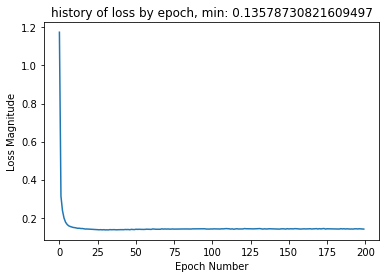

In [ ]:
# fit the model
model_all, history_all, callbacks_all =fit_log_model(Xb_all, Y_all.values.flatten(),
                                        my_layer=log_layer_scale_shift(1),
                                        adam_lr =0.1)

mse: 0.12795997318115432


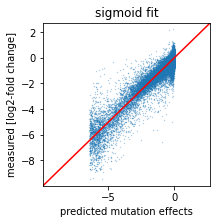

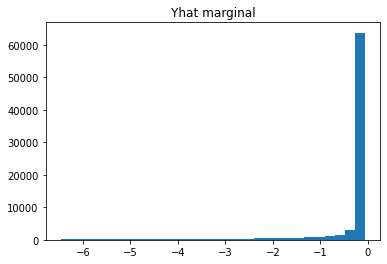

In [ ]:

fout = dout+'indep_all_sigmoid_alpha05'
corr_yhat_y(model_all.predict(Xb_all).flatten(), Y_all,
            fout=fout,
            s=0.1, 
            alpha=0.5,
            p_title = 'sigmoid fit'
            )

[(-13.216730117797852, -6.4666543), (-12.61068868637085, -6.4621396), (-12.19618844985962, -6.457045), (-12.189917087554932, -6.456951), (-12.089753150939941, -6.455361), (-11.97709608078003, -6.453373), (-11.837719917297363, -6.4505835), (-11.830332517623901, -6.450425), (-11.76546573638916, -6.448979), (-11.724602937698364, -6.448019), (-11.620964288711548, -6.445402), (-11.609034538269043, -6.4450836), (-11.555614233016968, -6.4436088), (-11.525476455688477, -6.4427414), (-11.456066846847534, -6.440643), (-11.442378759384155, -6.4402122), (-11.372650861740112, -6.437922), (-11.37064504623413, -6.4378543), (-11.33648419380188, -6.436671), (-11.316539764404297, -6.435962), (-11.296644449234009, -6.4352407), (-11.291267156600952, -6.435043), (-11.203033208847046, -6.431648), (-11.168949842453003, -6.430255), (-11.136415243148804, -6.4288816), (-11.132243871688843, -6.428702), (-11.106755495071411, -6.42759), (-11.102047681808472, -6.4273815), (-11.096598386764526, -6.427139), (-11.0694

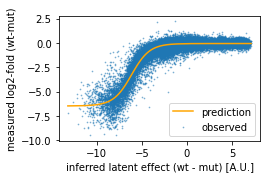

In [ ]:

scale_all, shift_all, w_all = model_all.get_weights()

plot_latent_y(model_all, df_doubles_flat_all, Xb_all, Y_all, w_all, t_bg_to_t_idx_all,  bg_to_b_idx_all,
              fout = dout+'independent_all_sigmoid_transformation')

In [ ]:
# save the predictions and write to file
df_muts =  make_df_results(model_all,Xb_all, df_doubles_flat_all, 
                           t_idx_to_t_bg_all, b_idx_to_bg_all,
                           t_bg_to_t_idx_all, bg_to_b_idx_all)

df_muts.to_csv(dout+'df_muts_high_antitoxin.csv')

# fit sigmoid to full dataset at low antitoxin conditions



(2075, 1)
layer0 weights set to:  [[0.6171142]
 [0.8422182]
 [0.783749 ]
 [0.7463618]
 [0.2935375]]
beta_hat [0.61711421 0.84221823 0.78374899 0.74636182 0.29353751]


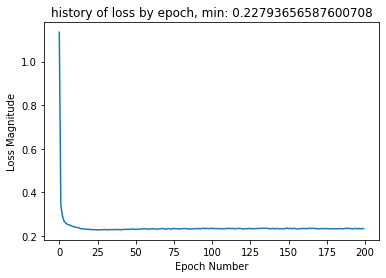

In [ ]:

# fit model 
model_all_h, history_all_h, callbacks_all_h =fit_log_model(Xb_all_h, Y_all_h.values.flatten(),
                                        my_layer=log_layer_scale_shift(1),
                                        adam_lr =0.1)

mse: 0.21555316660534507


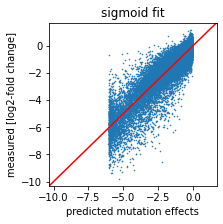

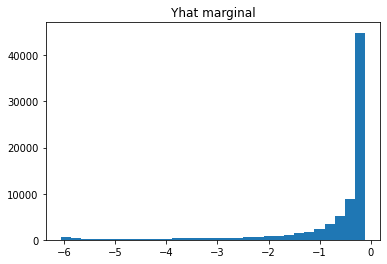

In [ ]:
fout = dout+'indep_all_sigmoid'
corr_yhat_y(model_all_h.predict(Xb_all_h).flatten(), Y_all_h,
            fout=fout,
            p_title = 'sigmoid fit'
            )

[(-9.310072183609009, -5.6479135), (-8.882036685943604, -5.6427703), (-8.716291427612305, -5.640112), (-8.61237096786499, -5.638207), (-8.612237453460693, -5.6382046), (-8.587689638137817, -5.637725), (-8.575317859649658, -5.6374784), (-8.556355953216553, -5.637096), (-8.553627252578735, -5.6370397), (-8.53013563156128, -5.6365533), (-8.520055055618286, -5.6363416), (-8.476194620132446, -5.635393), (-8.452016353607178, -5.6348534), (-8.442297220230103, -5.634632), (-8.430610418319702, -5.6343637), (-8.42423963546753, -5.634216), (-8.415579557418823, -5.634014), (-8.398367404937744, -5.6336064), (-8.382465839385986, -5.633224), (-8.368100881576538, -5.632873), (-8.358782291412354, -5.632643), (-8.316960096359253, -5.631583), (-8.302931785583496, -5.631218), (-8.290863752365112, -5.6308994), (-8.286646604537964, -5.6307874), (-8.280871629714966, -5.630633), (-8.239960670471191, -5.6295133), (-8.22891354560852, -5.6292033), (-8.204091787338257, -5.6284943), (-8.20203185081482, -5.628434),

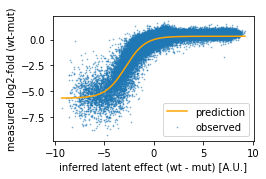

In [ ]:

scale_all_h, shift_all_h, w_all_h = model_all_h.get_weights()

plot_latent_y(model_all_h, df_doubles_flat_all_h, Xb_all_h, Y_all_h, w_all_h, t_bg_to_t_idx_all_h,  bg_to_b_idx_all_h,
              fout = dout+ 'independent_all_h_sigmoid_transformation')

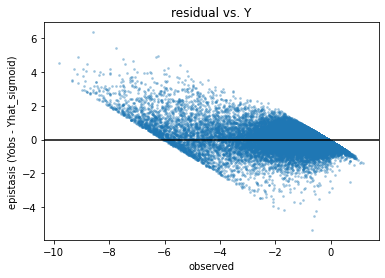

array([-0.02978284, -0.23314575, -0.20219887, ..., -0.8106267 ,
       -0.88528392, -0.11208193])

In [ ]:
plot_resid(Y_all_h, model_all_h.predict(Xb_all_h).flatten() - Y_all_h.values.flatten())

In [ ]:

df_muts_h =  make_df_results(model_all_h,Xb_all_h, df_doubles_flat_all_h, 
                           t_idx_to_t_bg_all_h, b_idx_to_bg_all_h,
                           t_bg_to_t_idx_all_h, bg_to_b_idx_all_h)

df_muts_h.to_csv(dout+'df_muts_low_antitoxin.csv')

#linear fits


In [ ]:
# linear model fit:
import statsmodels.api as sm
model = sm.OLS(Y_all,Xb_all).fit()
mse = np.mean((Y_all-model.predict())**2)
print(mse)


fout = dout+ 'indep_linear_all'
corr_yhat_y(model.predict(), Y_all,
            fout=fout,
            p_title = 'linear fit'
            )

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

df_muts['ols'] =model.predict()
df_muts.to_csv(dout+'df_results_all.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0.5412690391824078
mse: 0.5412690391824078


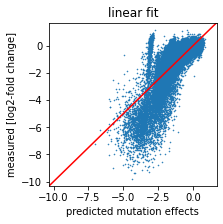

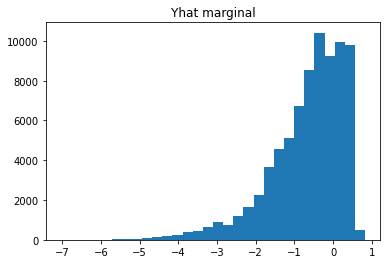

In [ ]:
# linear model fit:
import statsmodels.api as sm
model = sm.OLS(Y_all_h,Xb_all_h).fit()
mse = np.mean((Y_all_h-model.predict())**2)
print(mse)


fout = dout+'indep_linear_all_h'
corr_yhat_y(model.predict(), Y_all_h,
            fout=fout,
            p_title = 'linear fit'
            )

In [ ]:
# add a linear model fit to the low antitoxin data
df_muts_h = pd.read_csv(dout+'df_muts_low_antitoxin.csv', index_col =0)
df_muts_h['ols'] =model.predict()
df_muts_h.to_csv(dout+'df_muts_low_antitoxin.csv')